In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import os
from matplotlib_venn import venn2


In [3]:
os.listdir()

['ACT_query.ipynb',
 'ACT_result_summary.txt',
 'ACT_result_summary_table.xlsx',
 'ACT_UMAP.ipynb',
 'ACT_venn.ipynb',
 'HCC_ACT_result_liver_16_19.txt',
 'HCC_ACT_result_liver_FINAL.txt',
 'HCC_ACT_result_liver_lymph_node.txt',
 'Human_Liver_marker.txt',
 'Leiden_marker_overlap.txt']

In [4]:
marker_df = pd.read_csv('Human_Liver_marker.txt', sep='\t')
print(marker_df.shape)
marker_df.head()

(109, 5)


,Species,Tissue,CellType,Marker,Resource
0,Human,Liver,"Activated CD4-positive, alpha-beta T cell","ANXA1, BATF, CD3D, CD4, CD69, GATA3, ICA1, IFI...","33248023, 35964553, 32426177"
1,Human,Liver,Alternatively activated macrophage,CD163,34140495
2,Human,Liver,B cell,"CD79A, MS4A1, CD19, IGHG1, MZB1, BLNK, CD79B, ...","34792289, 34497364, 33287869, 35549406, 351839..."
3,Human,Liver,Cancer-associated fibroblast,"ACTA2, BGN, COL1A2","33619115, 33332768"
4,Human,Liver,"CD14-low, CD16-positive monocyte","CD14, CD68, FCGR3A",35903097


In [5]:
marker_df['CellType'].unique()

array(['Activated CD4-positive, alpha-beta T cell',
       'Alternatively activated macrophage', 'B cell',
       'Cancer-associated fibroblast', 'CD14-low, CD16-positive monocyte',
       'CD14-positive monocyte', 'CD14-positive, CD16-positive monocyte',
       'CD141-positive myeloid dendritic cell',
       'CD16-negative natural killer cell',
       'CD16-positive natural killer cell',
       'CD1c-positive myeloid dendritic cell',
       'CD4-positive helper T cell',
       'CD4-positive, alpha-beta exhausted T cell',
       'CD4-positive, alpha-beta memory T cell',
       'CD4-positive, alpha-beta T cell',
       'CD4-positive, CD25-positive, alpha-beta regulatory T cell',
       'CD8-positive, alpha-beta cytotoxic T cell',
       'CD8-positive, alpha-beta exhausted T cell',
       'CD8-positive, alpha-beta memory T cell',
       'CD8-positive, alpha-beta T cell',
       'Central memory CD4-positive, alpha-beta T cell', 'Cholangiocyte',
       'Circulating effector memory T cell',

## Read PreLect features k3

In [6]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\HCC_case_study\feature_selection_k3")
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/HCC_case_study/feature_selection_k3')
os.chdir(source_code_dir / 'HCC_case_study/feature_selection_k3')

features_dict = {}
# Read features for each leiden cluster
clusters = [f"Leiden_{i}" for i in range(24)]
for celltype in clusters:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        feature_df['abs_weight'] = feature_df['Weight'].abs()
        feature_df = feature_df.sort_values(by=['Tendency', 'abs_weight'], ascending=[False, False])
        feature_df.drop(columns=['abs_weight'], inplace=True)
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
# row_order = [f'Leiden_{i}' for i in range(24)]
# count_df = count_df.loc[row_order]
count_df

,Feature_count,Positive_feature_count
Leiden_0,41,27
Leiden_1,91,44
Leiden_2,32,13
Leiden_3,117,60
Leiden_4,34,21
Leiden_5,182,69
Leiden_6,38,21
Leiden_7,63,30
Leiden_8,99,48
Leiden_9,69,42


In [7]:
# Do two comparisons:
#   1. All_PreLect vs. Marker in database
#   2. Positive_PreLect vs. Marker in database
def compare_PreLect_w_marker(celltype, PreLect_dict, marker_genes, name=''):
    if name == '':
        name = celltype
    # Extracting the features and marker genes
    feature_df = PreLect_dict[celltype]
    features = feature_df['Gene'].tolist()
    positve_features = feature_df[feature_df['Tendency'] == 1]['Gene'].tolist()
    # marker_genes = marker_df['official gene symbol'].tolist()

    ### All features
    # Finding common elements
    common_all = list(set(features) & set(marker_genes))
    if len(common_all) == 0:
        print('ZERO feature common with markers')
        return (None, None)
    print(celltype, 'All features common with markers:', len(common_all))
    # Preparing sets for Venn diagram
    features_set = set(features)
    marker_genes_set = set(marker_genes)
    # Plotting Venn diagram
    plt.figure(figsize=(8, 5))
    v = venn2([features_set, marker_genes_set], set_labels=('PreLect all', f'{name} Marker'))
    for idx in ('10', '01', '11'):  # Each region in a 2-set Venn diagram
        if v.get_label_by_id(idx) and int(v.get_label_by_id(idx).get_text()) == 0:
            v.get_label_by_id(idx).set_text('')
    # plt.title(name, fontsize=16)
    plt.title(celltype, fontsize=16)
    for text in v.set_labels:
        text.set_fontsize(10)  # 14
    for text in v.subset_labels:
        text.set_fontsize(16)
    plt.show()

    ### Positive features
    # Finding common elements
    common_positive = list(set(positve_features) & set(marker_genes))
    print(celltype, 'Positive features common with markers:', len(common_positive))
    # Preparing sets for Venn diagram
    positive_features_set = set(positve_features)
    marker_genes_set = set(marker_genes)
    # Plotting Venn diagram
    plt.figure(figsize=(8, 5))
    v = venn2([positive_features_set, marker_genes_set], set_labels=('PreLect positive', f'{name} Marker'), set_colors=('blue', 'green'))
    for idx in ('10', '01', '11'):  # Each region in a 2-set Venn diagram
        if v.get_label_by_id(idx) and int(v.get_label_by_id(idx).get_text()) == 0:
            v.get_label_by_id(idx).set_text('')
    # plt.title(name, fontsize=16)
    plt.title(celltype, fontsize=16)
    for text in v.set_labels:
        # print(text)
        text.set_fontsize(10)  # 14
    for text in v.subset_labels:
        text.set_fontsize(16)
    plt.show()

    return common_all, common_positive


In [8]:
def get_celltype_marker(name, marker_df):
    string = marker_df[marker_df['CellType'] == name]['Marker'].tolist()[0]
    marker_list = string.split(', ')
    return marker_list

## Function for running comparison

In [9]:
def run_compare(clus_name, act_name, features_dict, marker_df, marker_list=None):
    if marker_list:
        common, common_p = compare_PreLect_w_marker(clus_name, features_dict, marker_list, name=act_name)  # name=clus_name
    else:
        common, common_p = compare_PreLect_w_marker(clus_name, features_dict, get_celltype_marker(act_name, marker_df), name=act_name)  # name=clus_name
    print(f'{clus_name}_common:', common)
    print(f'{clus_name}_common_p:', common_p)

In [13]:
leiden_2_ACT_name = {
    "Leiden_0": ["Hepatocyte"],
    "Leiden_1": ["CD4-positive, alpha-beta T cell", "Effector memory CD8-positive, alpha-beta T cell", "Effector memory CD4-positive, alpha-beta T cell"],
    "Leiden_2": ["Kupffer cell", "Tumor-associated macrophage"],
    "Leiden_3": ["Monocyte", "Dendritic cell"],
    "Leiden_4": ["Hepatocyte"],
    "Leiden_5": ["Natural killer cell"],
    "Leiden_6": ["Endothelial cell"],
    "Leiden_7": ["Effector memory CD8-positive, alpha-beta T cell", "Effector memory CD4-positive, alpha-beta T cell", "T cell"],
    "Leiden_8": ["Natural killer cell"],
    "Leiden_9": ["Cholangiocyte", "Hepatic oval stem cell"],
    "Leiden_10": ["Plasma cell", "B cell"],
    "Leiden_11": ["Fibroblast"],
    "Leiden_12": ["Regulatory T cell"],
    "Leiden_13": ["B cell"],
    "Leiden_14": ["Kupffer cell", "Macrophage", "T cell"],
    "Leiden_15": ["Hepatocyte"],
    "Leiden_16": ["Cholangiocyte"],
    "Leiden_17": ["Hepatocyte"],
    "Leiden_18": ["Kupffer cell"],
    "Leiden_19": ["Kupffer cell", 'Macrophage'],
    "Leiden_20": ["Kupffer cell"],
    "Leiden_21": ["Kupffer cell"],
    "Leiden_23": ["Kupffer cell"],
}


Leiden_0 Hepatocyte
Leiden_0 All features common with markers: 5


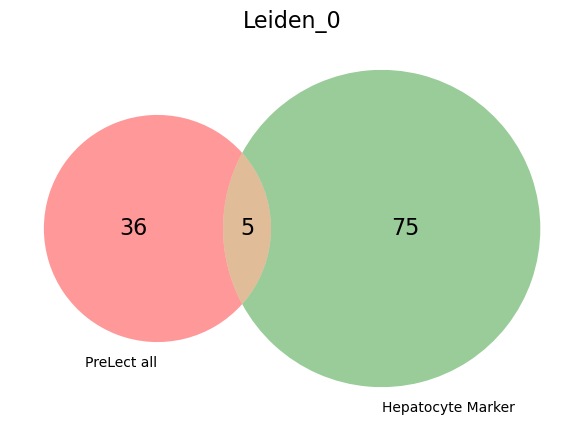

Leiden_0 Positive features common with markers: 3


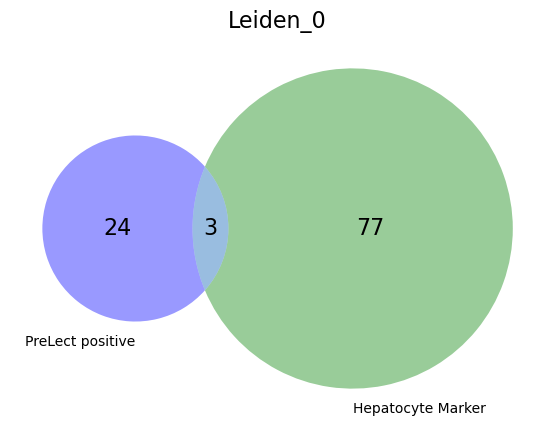

Leiden_0_common: ['APOA1', 'KRT18', 'SPINK1', 'SERPINA1', 'ALB']
Leiden_0_common_p: ['SPINK1', 'SERPINA1', 'KRT18']


In [11]:
# Try one
clus = list(leiden_2_ACT_name.keys())[0]
name = leiden_2_ACT_name[clus][0]
print(clus, name)
run_compare(clus, name, features_dict, marker_df)

Leiden_0 Hepatocyte
Leiden_0 All features common with markers: 5


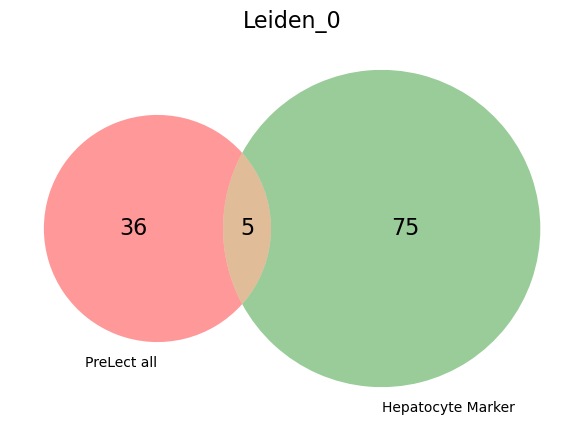

Leiden_0 Positive features common with markers: 3


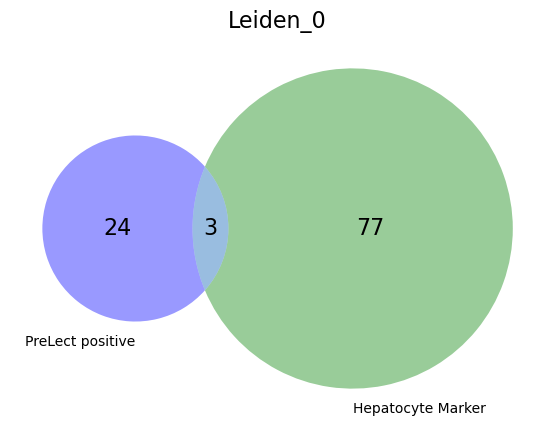

Leiden_0_common: ['APOA1', 'KRT18', 'SPINK1', 'SERPINA1', 'ALB']
Leiden_0_common_p: ['SPINK1', 'SERPINA1', 'KRT18']
Leiden_1 CD4-positive, alpha-beta T cell
Leiden_1 All features common with markers: 4


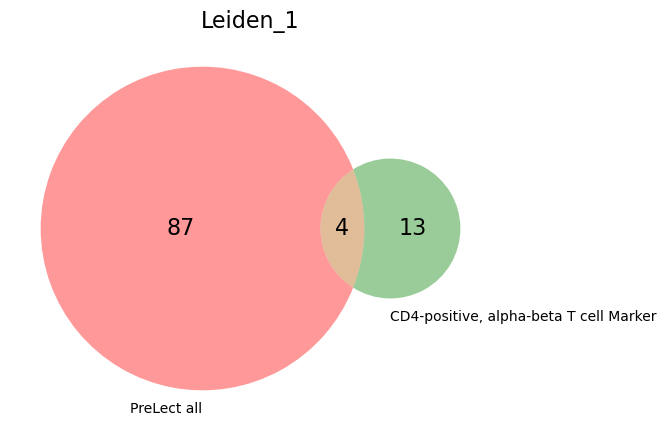

Leiden_1 Positive features common with markers: 4


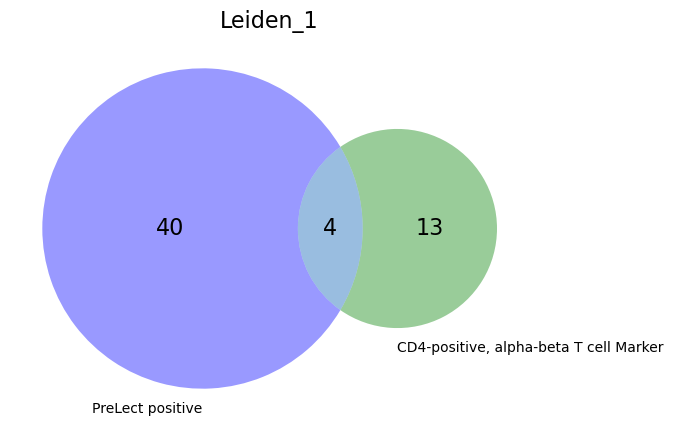

Leiden_1_common: ['CD3D', 'IL7R', 'LTB', 'CD3E']
Leiden_1_common_p: ['CD3D', 'IL7R', 'LTB', 'CD3E']
Leiden_1 Effector memory CD8-positive, alpha-beta T cell
Leiden_1 All features common with markers: 6


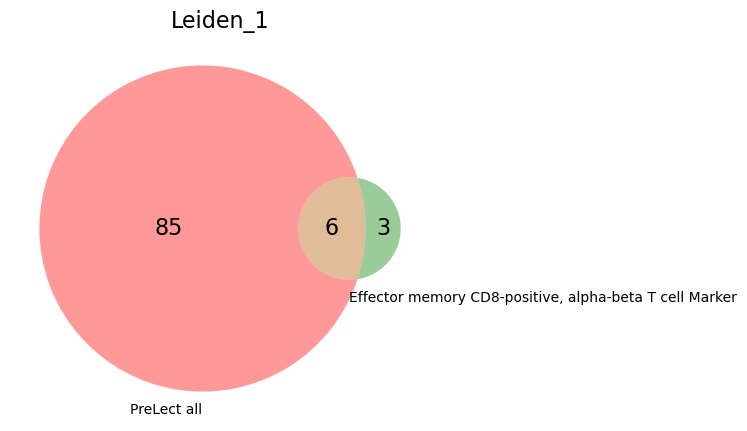

Leiden_1 Positive features common with markers: 5


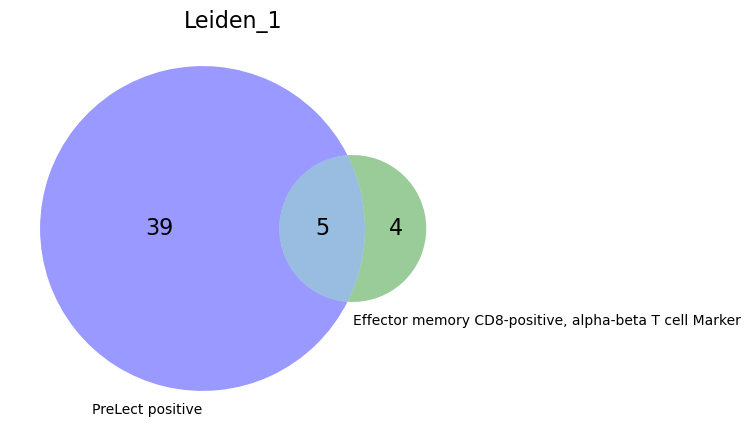

Leiden_1_common: ['CCL5', 'CXCR4', 'NKG7', 'CD3E', 'GZMK', 'CD3D']
Leiden_1_common_p: ['CCL5', 'CXCR4', 'CD3E', 'GZMK', 'CD3D']
Leiden_1 Effector memory CD4-positive, alpha-beta T cell
Leiden_1 All features common with markers: 2


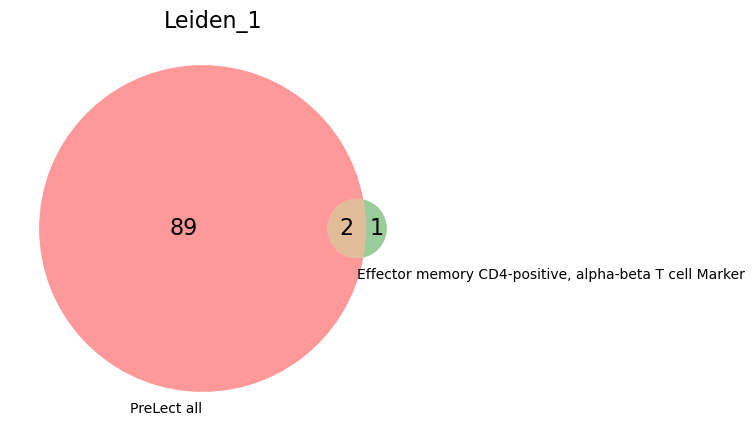

Leiden_1 Positive features common with markers: 2


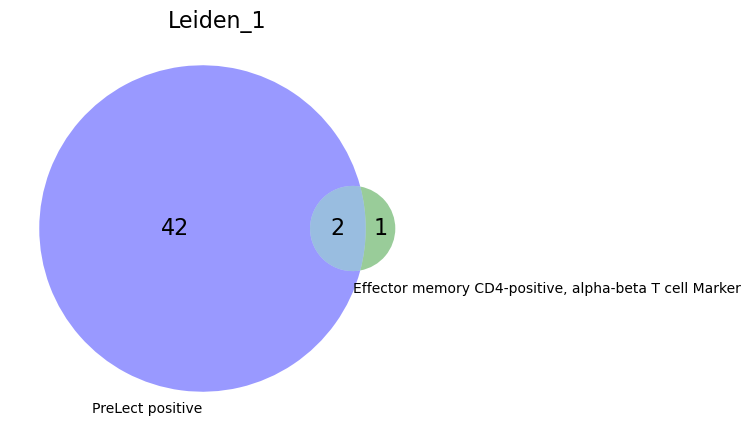

Leiden_1_common: ['CCL5', 'ANXA1']
Leiden_1_common_p: ['CCL5', 'ANXA1']
Leiden_2 Kupffer cell
Leiden_2 All features common with markers: 2


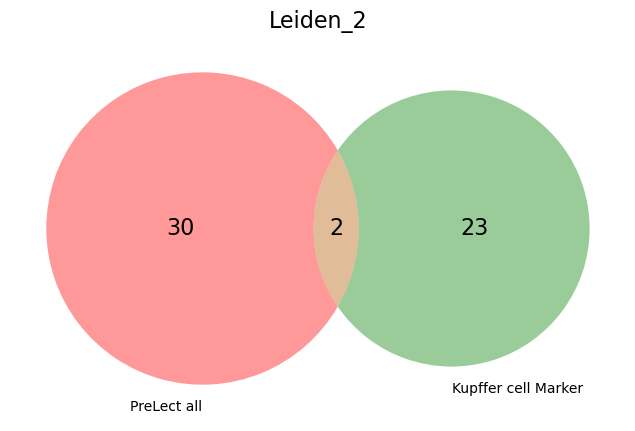

Leiden_2 Positive features common with markers: 2


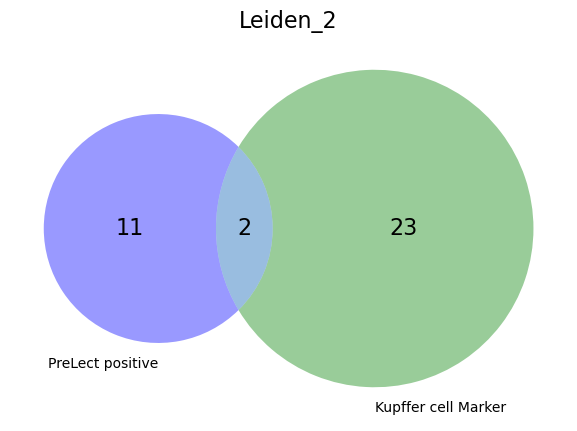

Leiden_2_common: ['C1QB', 'C1QA']
Leiden_2_common_p: ['C1QB', 'C1QA']
Leiden_2 Tumor-associated macrophage
Leiden_2 All features common with markers: 2


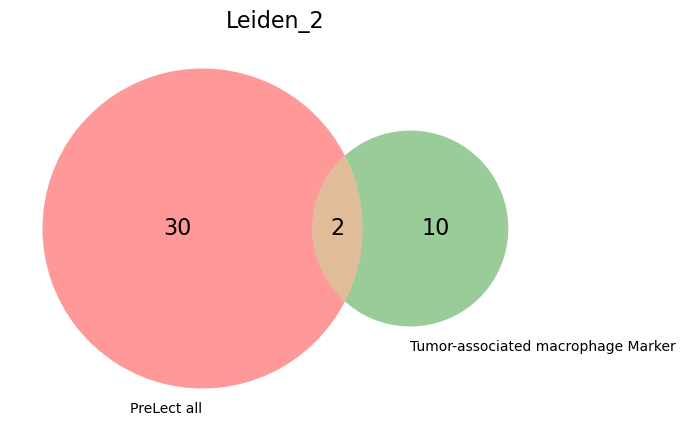

Leiden_2 Positive features common with markers: 2


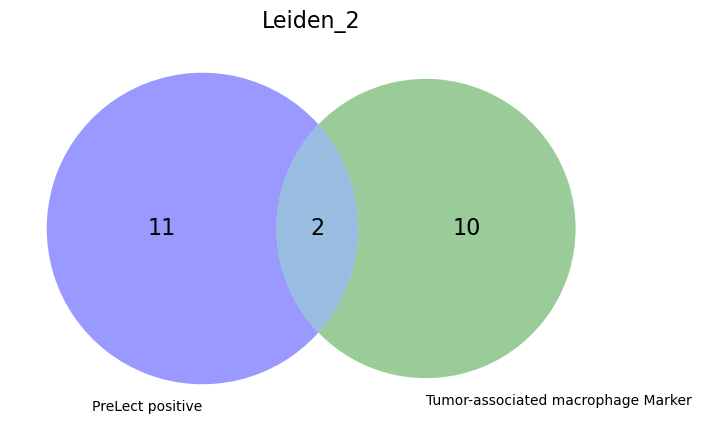

Leiden_2_common: ['C1QA', 'C1QC']
Leiden_2_common_p: ['C1QA', 'C1QC']
Leiden_3 Monocyte
Leiden_3 All features common with markers: 4


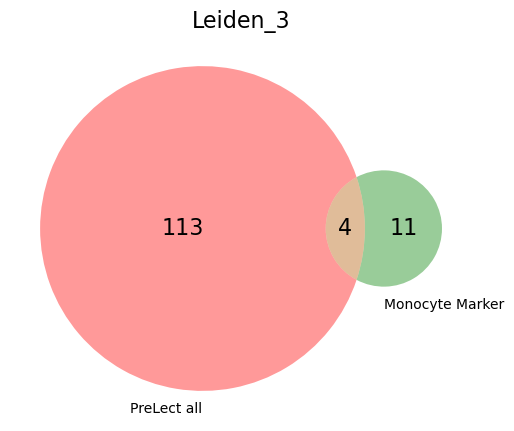

Leiden_3 Positive features common with markers: 4


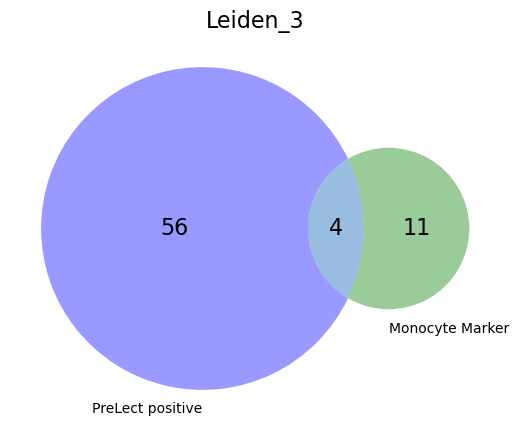

Leiden_3_common: ['LYZ', 'FCN1', 'LST1', 'COTL1']
Leiden_3_common_p: ['LYZ', 'FCN1', 'LST1', 'COTL1']
Leiden_3 Dendritic cell
Leiden_3 All features common with markers: 6


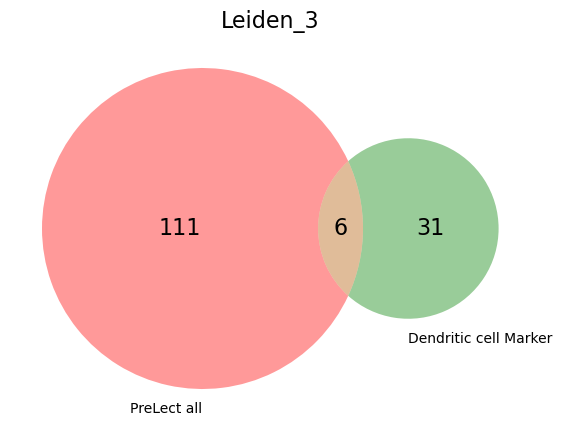

Leiden_3 Positive features common with markers: 6


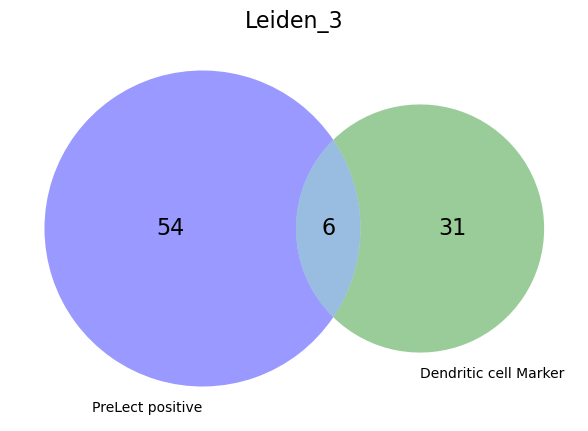

Leiden_3_common: ['HLA-DRA', 'CST3', 'HLA-DPA1', 'HLA-DPB1', 'LYZ', 'HLA-DQB1']
Leiden_3_common_p: ['HLA-DRA', 'CST3', 'HLA-DPA1', 'HLA-DPB1', 'LYZ', 'HLA-DQB1']
Leiden_4 Hepatocyte
Leiden_4 All features common with markers: 4


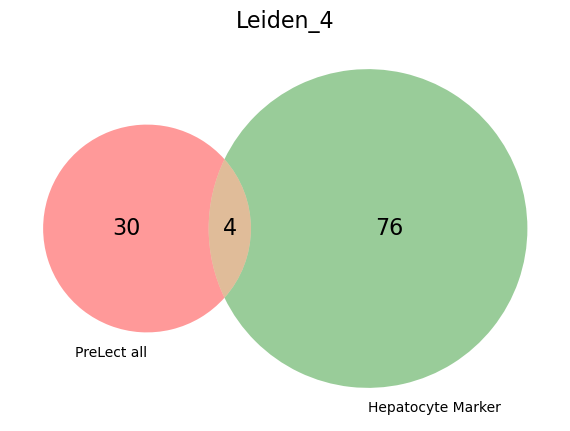

Leiden_4 Positive features common with markers: 4


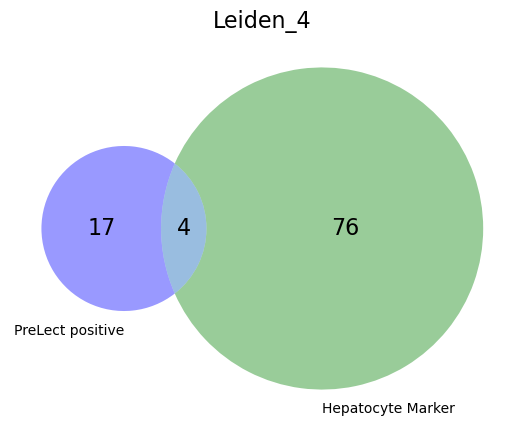

Leiden_4_common: ['APOA1', 'APOA2', 'SERPINA1', 'ALB']
Leiden_4_common_p: ['APOA1', 'APOA2', 'SERPINA1', 'ALB']
Leiden_5 Natural killer cell
Leiden_5 All features common with markers: 20


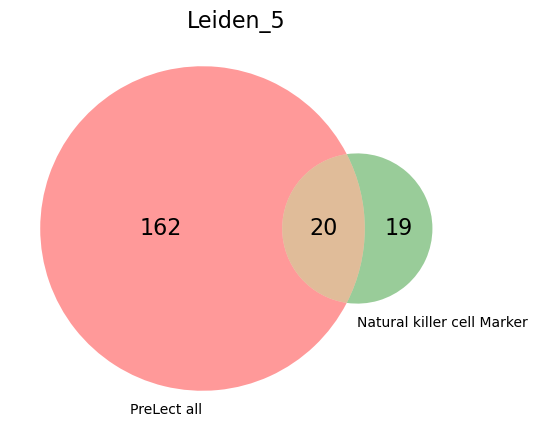

Leiden_5 Positive features common with markers: 16


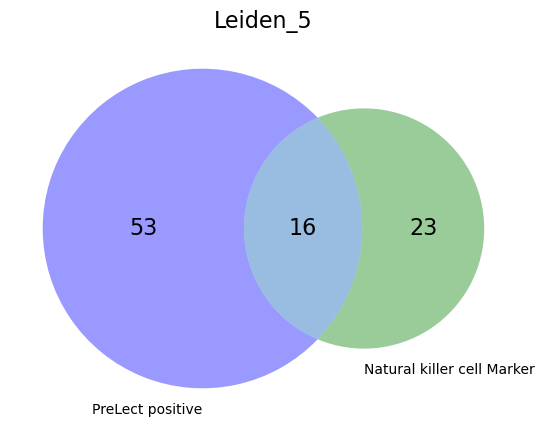

Leiden_5_common: ['FGFBP2', 'ZNF331', 'CST7', 'CD69', 'KLRD1', 'NKG7', 'HMGB2', 'CD3D', 'CD7', 'HSPA1A', 'GNLY', 'HSPA1B', 'CD3E', 'DNAJB1', 'FCGR3A', 'GZMB', 'CCL5', 'PRF1', 'GZMK', 'IL32']
Leiden_5_common_p: ['FCGR3A', 'GZMB', 'CCL5', 'FGFBP2', 'KLRD1', 'PRF1', 'NKG7', 'CD3E', 'IL32', 'CST7', 'DNAJB1', 'CD3D', 'HSPA1A', 'GNLY', 'CD69', 'HSPA1B']
Leiden_6 Endothelial cell
Leiden_6 All features common with markers: 5


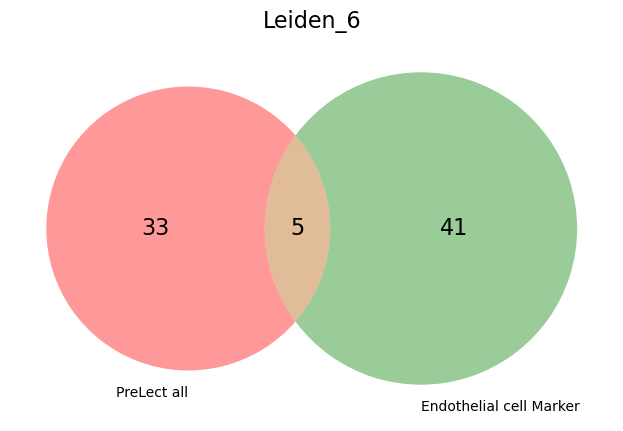

Leiden_6 Positive features common with markers: 5


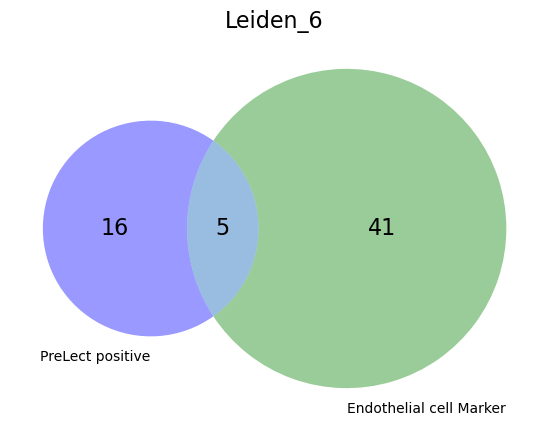

Leiden_6_common: ['DNASE1L3', 'ENG', 'SPARC', 'FCN3', 'TM4SF1']
Leiden_6_common_p: ['DNASE1L3', 'ENG', 'SPARC', 'FCN3', 'TM4SF1']
Leiden_7 Effector memory CD8-positive, alpha-beta T cell
Leiden_7 All features common with markers: 5


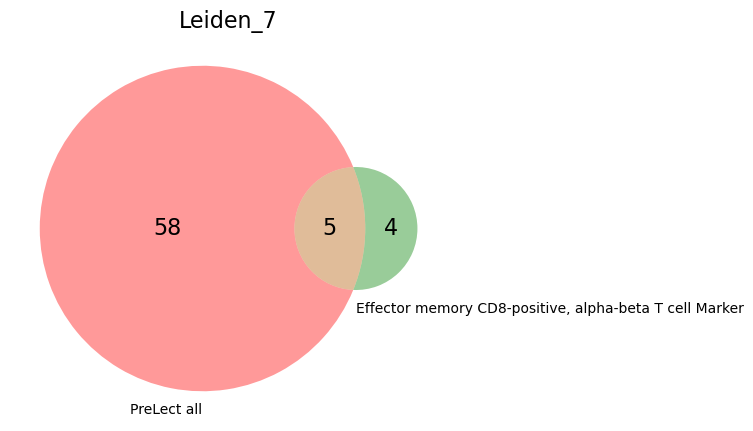

Leiden_7 Positive features common with markers: 5


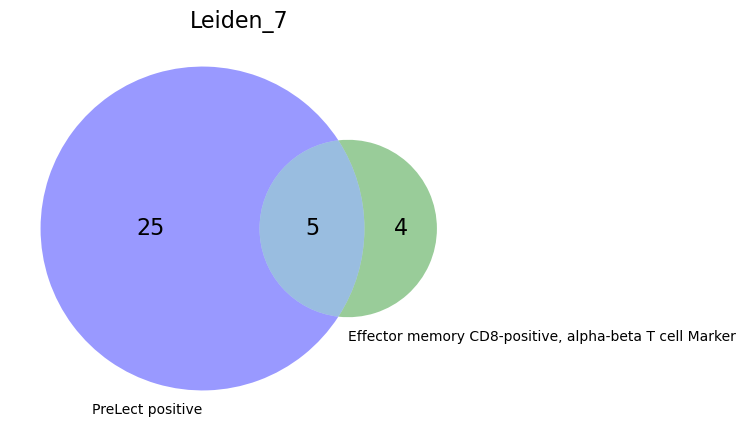

Leiden_7_common: ['CCL5', 'CXCR4', 'CD3E', 'GZMK', 'CD3D']
Leiden_7_common_p: ['CCL5', 'CXCR4', 'CD3E', 'GZMK', 'CD3D']
Leiden_7 Effector memory CD4-positive, alpha-beta T cell
Leiden_7 All features common with markers: 1


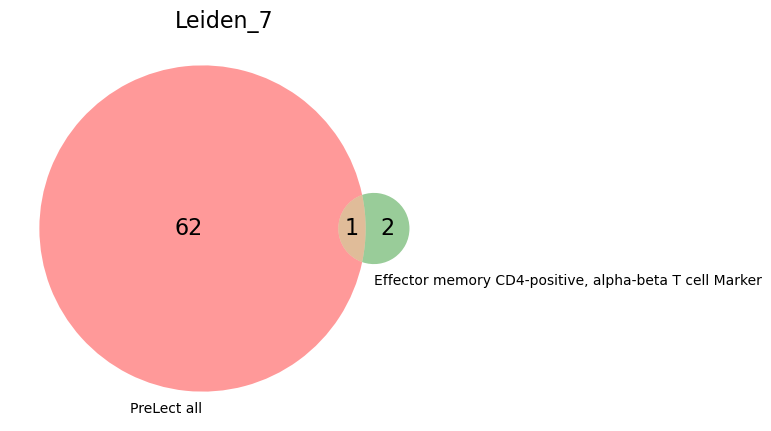

Leiden_7 Positive features common with markers: 1


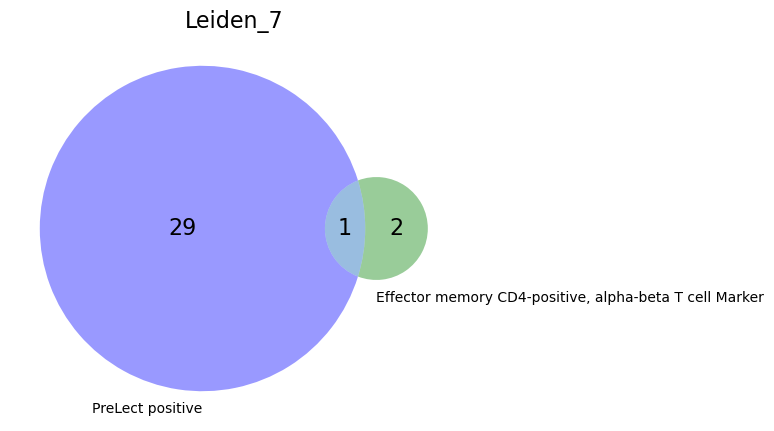

Leiden_7_common: ['CCL5']
Leiden_7_common_p: ['CCL5']
Leiden_7 T cell
Leiden_7 All features common with markers: 8


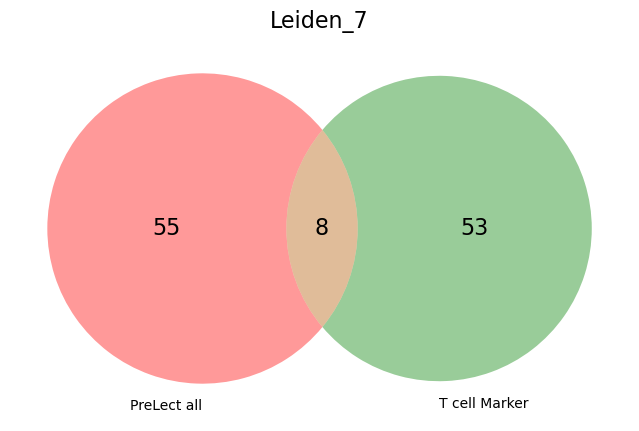

Leiden_7 Positive features common with markers: 8


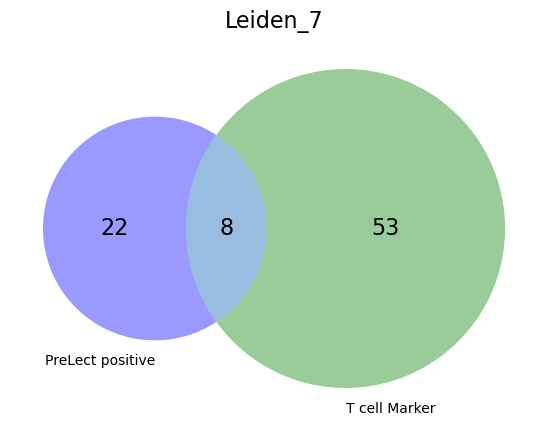

Leiden_7_common: ['PTPRC', 'CCL5', 'CMC1', 'TRBC2', 'CD3E', 'IL32', 'GZMK', 'CD3D']
Leiden_7_common_p: ['PTPRC', 'CCL5', 'CMC1', 'TRBC2', 'CD3E', 'GZMK', 'IL32', 'CD3D']
Leiden_8 Natural killer cell
Leiden_8 All features common with markers: 15


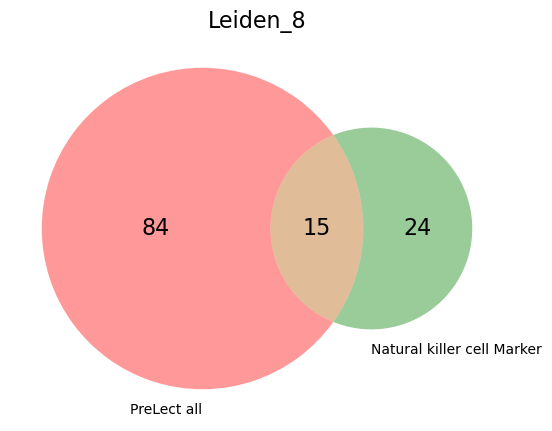

Leiden_8 Positive features common with markers: 12


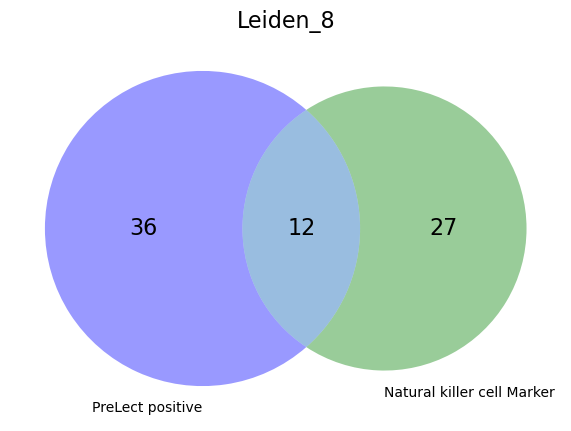

Leiden_8_common: ['CD160', 'KLRB1', 'GZMB', 'CXCR4', 'KLRD1', 'PRF1', 'AREG', 'NKG7', 'GZMK', 'ZNF331', 'XCL1', 'DNAJB1', 'KLRF1', 'CD7', 'HSPA1A']
Leiden_8_common_p: ['CD160', 'KLRB1', 'KLRD1', 'AREG', 'NKG7', 'GZMK', 'ZNF331', 'XCL1', 'DNAJB1', 'KLRF1', 'CD7', 'HSPA1A']
Leiden_9 Cholangiocyte
Leiden_9 All features common with markers: 5


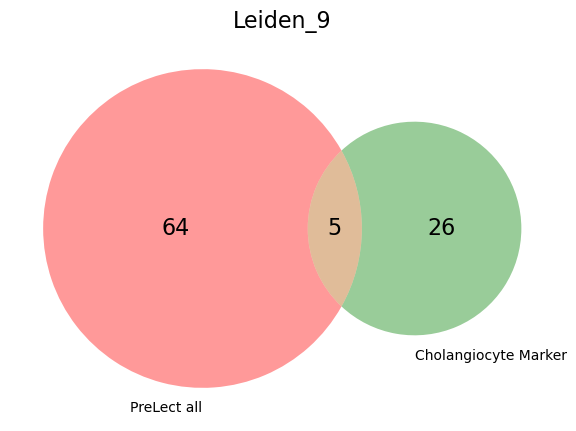

Leiden_9 Positive features common with markers: 5


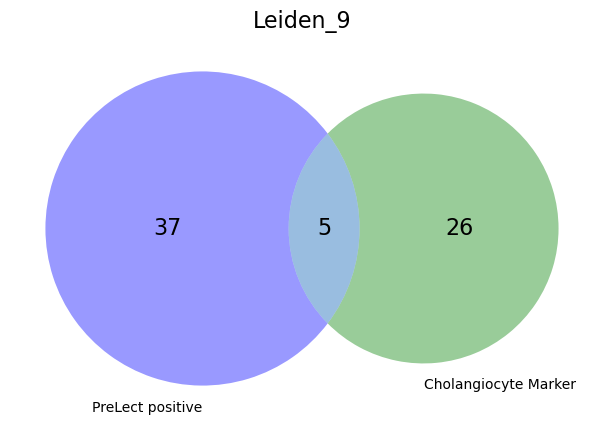

Leiden_9_common: ['CD24', 'KRT18', 'KRT8', 'ANXA4', 'TM4SF4']
Leiden_9_common_p: ['CD24', 'KRT18', 'KRT8', 'ANXA4', 'TM4SF4']
Leiden_9 Hepatic oval stem cell
Leiden_9 All features common with markers: 2


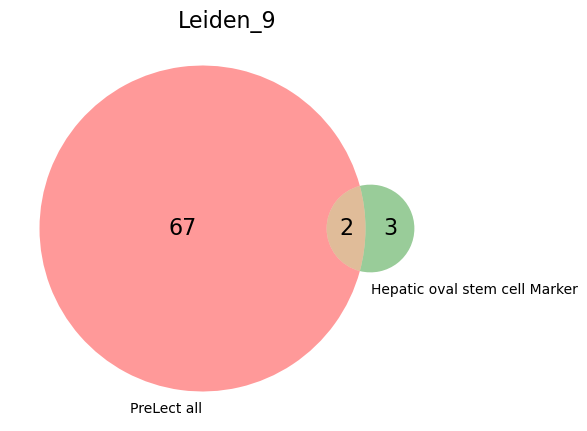

Leiden_9 Positive features common with markers: 2


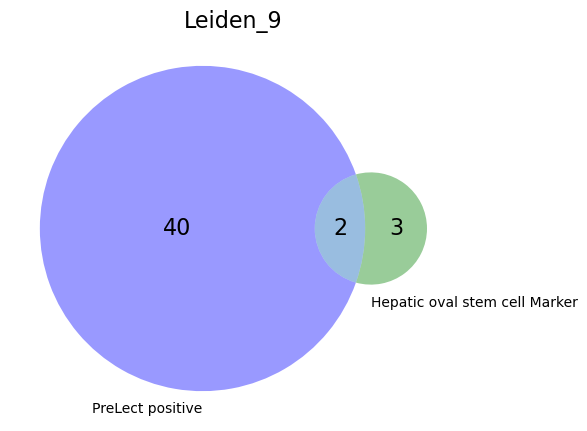

Leiden_9_common: ['KRT8', 'KRT18']
Leiden_9_common_p: ['KRT8', 'KRT18']
Leiden_10 Plasma cell
Leiden_10 All features common with markers: 7


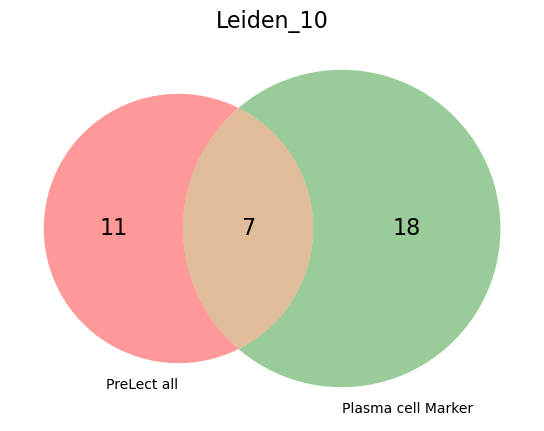

Leiden_10 Positive features common with markers: 7


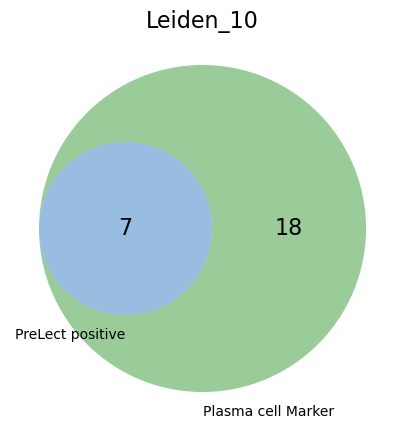

Leiden_10_common: ['IGHG3', 'MZB1', 'IGLC2', 'JCHAIN', 'IGKC', 'IGHG4', 'IGHG1']
Leiden_10_common_p: ['IGHG3', 'MZB1', 'IGLC2', 'JCHAIN', 'IGKC', 'IGHG4', 'IGHG1']
Leiden_10 B cell
Leiden_10 All features common with markers: 3


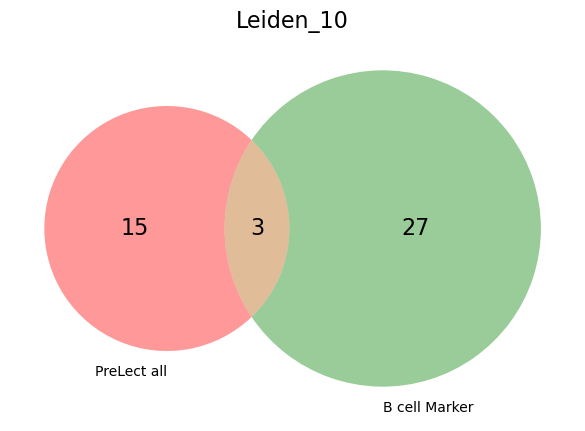

Leiden_10 Positive features common with markers: 3


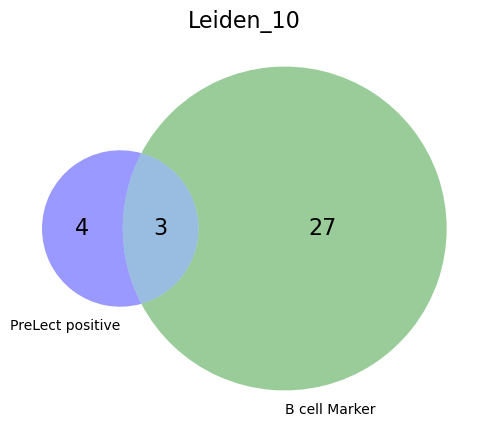

Leiden_10_common: ['IGHG4', 'IGHG1', 'MZB1']
Leiden_10_common_p: ['IGHG4', 'IGHG1', 'MZB1']
Leiden_11 Fibroblast
Leiden_11 All features common with markers: 8


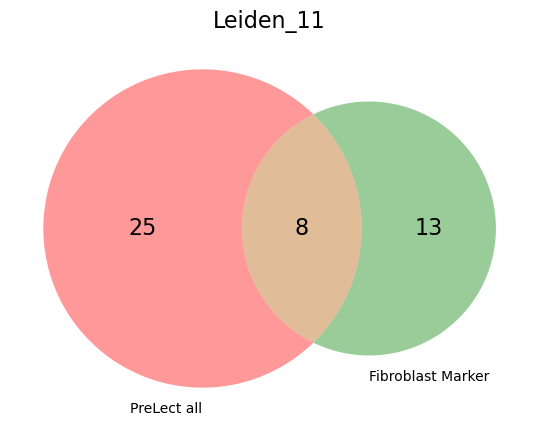

Leiden_11 Positive features common with markers: 8


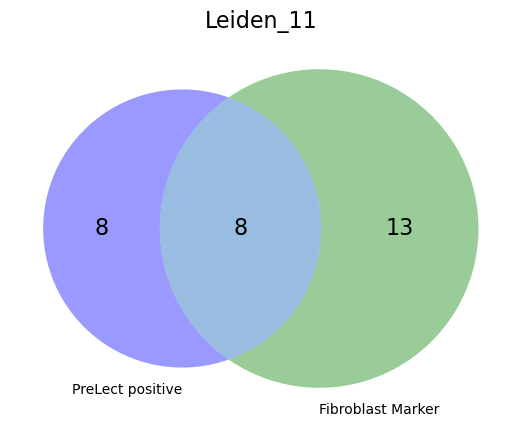

Leiden_11_common: ['COL3A1', 'COL1A2', 'IGFBP7', 'MYL9', 'SPARC', 'TPM2', 'DCN', 'CALD1']
Leiden_11_common_p: ['COL3A1', 'COL1A2', 'IGFBP7', 'MYL9', 'SPARC', 'TPM2', 'DCN', 'CALD1']
Leiden_12 Regulatory T cell
Leiden_12 All features common with markers: 3


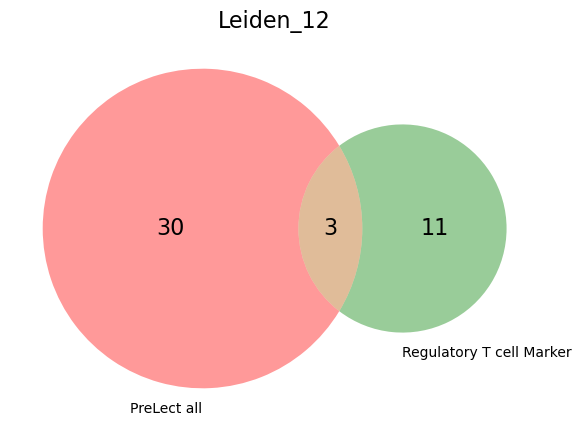

Leiden_12 Positive features common with markers: 3


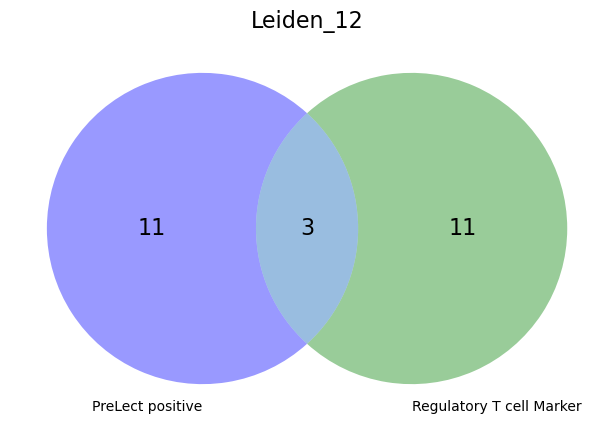

Leiden_12_common: ['TIGIT', 'BATF', 'CD3D']
Leiden_12_common_p: ['TIGIT', 'BATF', 'CD3D']
Leiden_13 B cell
Leiden_13 All features common with markers: 5


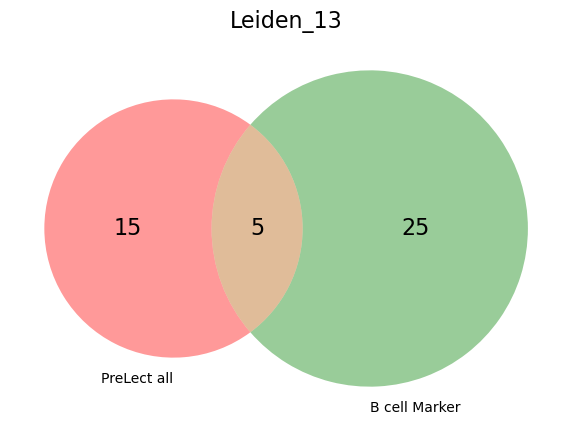

Leiden_13 Positive features common with markers: 4


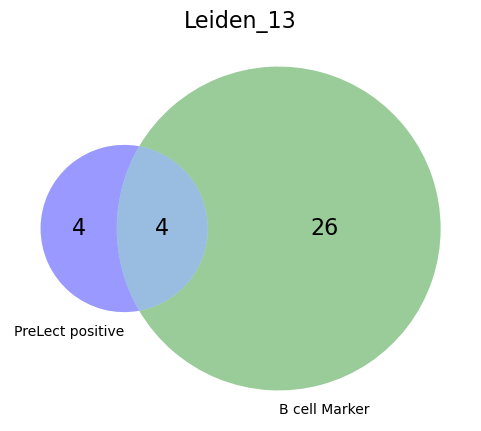

Leiden_13_common: ['HLA-DRA', 'CD74', 'MS4A1', 'CD79A', 'IGHG1']
Leiden_13_common_p: ['MS4A1', 'HLA-DRA', 'CD79A', 'CD74']
Leiden_14 Kupffer cell
ZERO feature common with markers
Leiden_14_common: None
Leiden_14_common_p: None
Leiden_14 Macrophage
Leiden_14 All features common with markers: 2


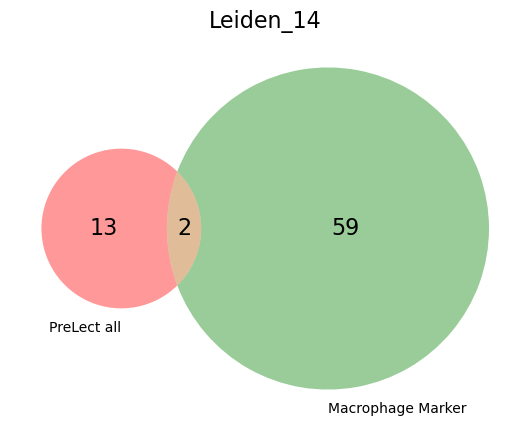

Leiden_14 Positive features common with markers: 1


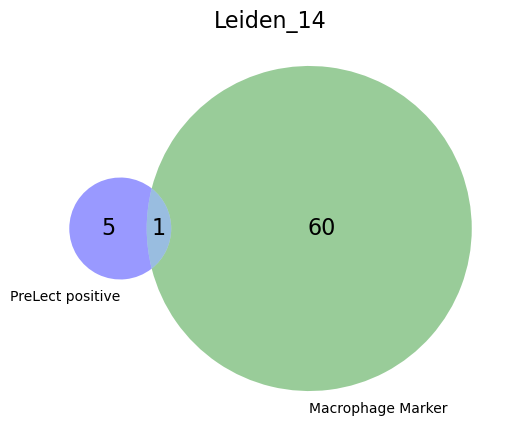

Leiden_14_common: ['STMN1', 'MT-ND2']
Leiden_14_common_p: ['STMN1']
Leiden_14 T cell
Leiden_14 All features common with markers: 2


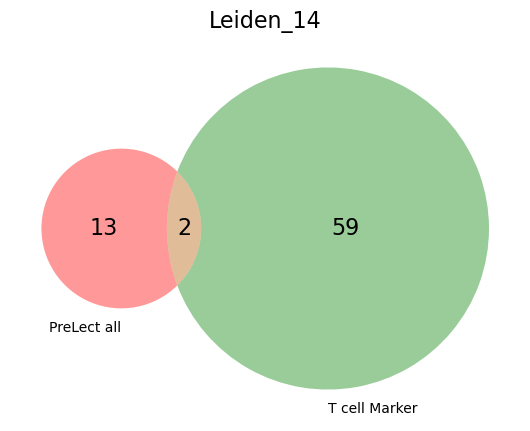

Leiden_14 Positive features common with markers: 2


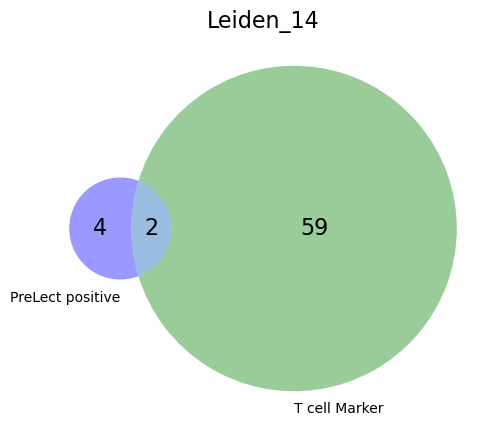

Leiden_14_common: ['STMN1', 'HMGB2']
Leiden_14_common_p: ['STMN1', 'HMGB2']
Leiden_15 Hepatocyte
Leiden_15 All features common with markers: 4


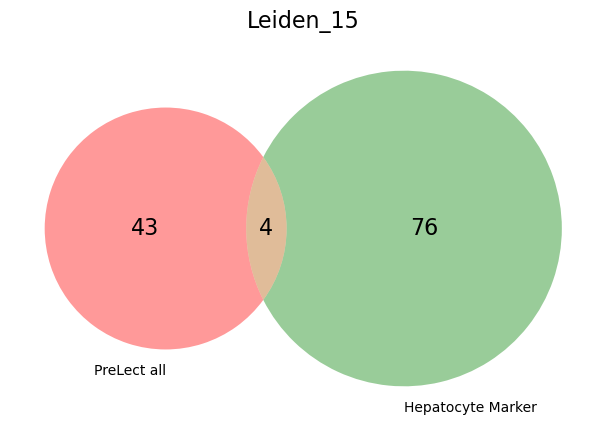

Leiden_15 Positive features common with markers: 3


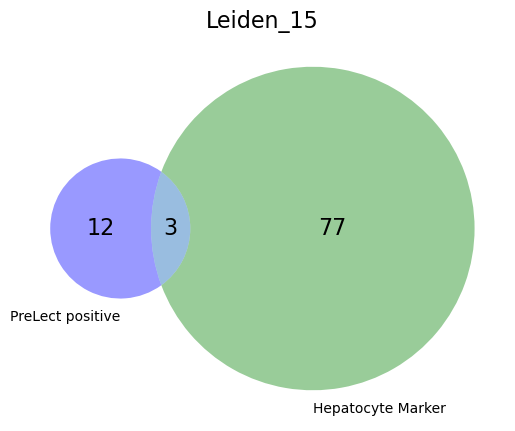

Leiden_15_common: ['KRT8', 'APOC3', 'TF', 'SERPINA1']
Leiden_15_common_p: ['KRT8', 'TF', 'SERPINA1']
Leiden_16 Cholangiocyte
Leiden_16 All features common with markers: 6


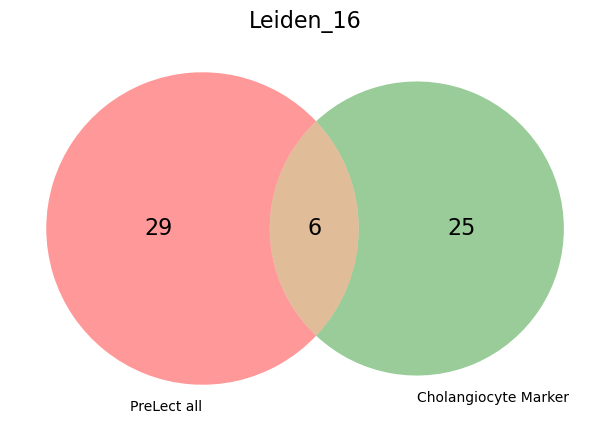

Leiden_16 Positive features common with markers: 6


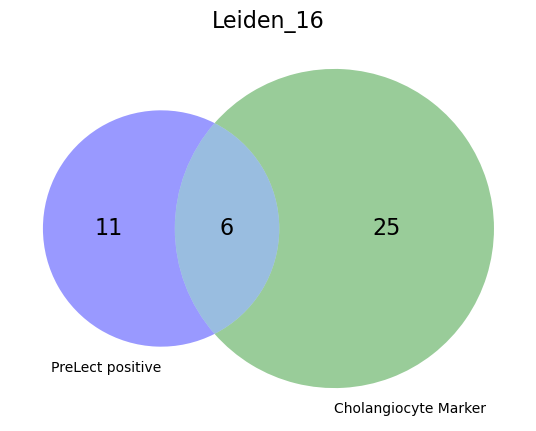

Leiden_16_common: ['ELF3', 'KRT18', 'KRT8', 'DEFB1', 'FXYD2', 'ANXA4']
Leiden_16_common_p: ['ELF3', 'KRT18', 'KRT8', 'DEFB1', 'FXYD2', 'ANXA4']
Leiden_17 Hepatocyte
Leiden_17 All features common with markers: 4


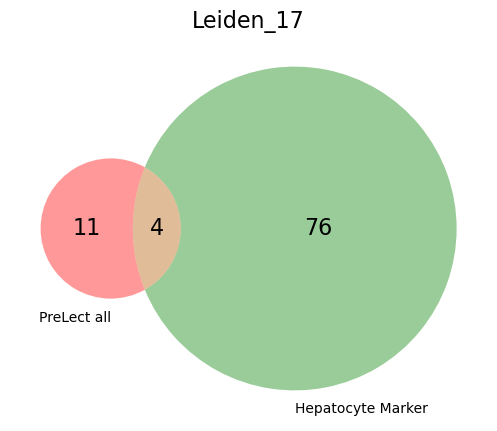

Leiden_17 Positive features common with markers: 4


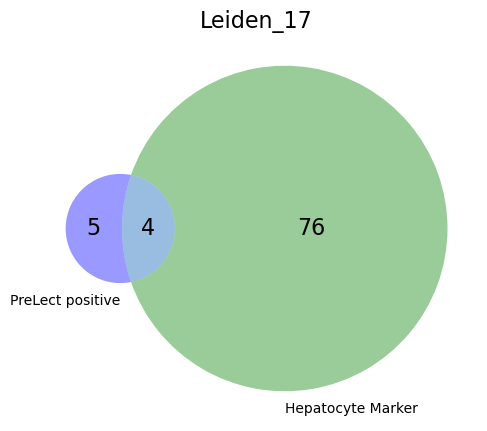

Leiden_17_common: ['APOA1', 'APOC3', 'ORM1', 'HP']
Leiden_17_common_p: ['APOA1', 'APOC3', 'ORM1', 'HP']
Leiden_18 Kupffer cell
Leiden_18 All features common with markers: 4


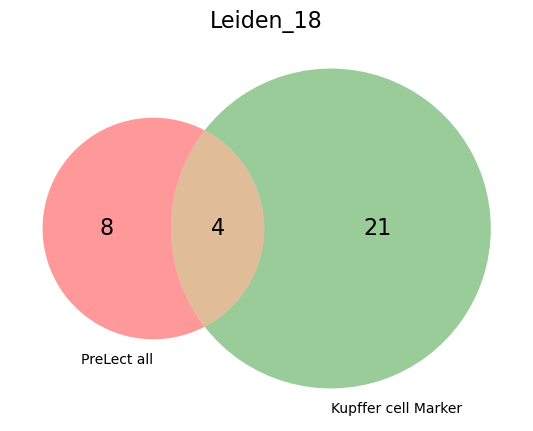

Leiden_18 Positive features common with markers: 4


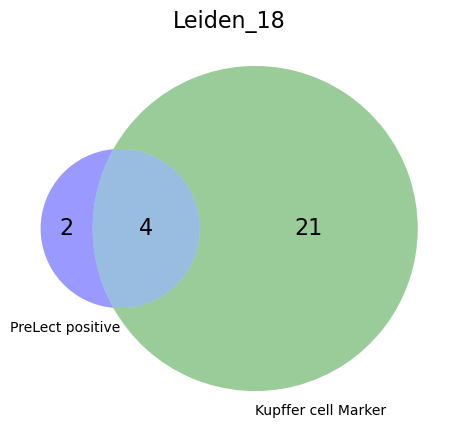

Leiden_18_common: ['MARCO', 'C1QA', 'C1QB', 'CD5L']
Leiden_18_common_p: ['MARCO', 'C1QA', 'C1QB', 'CD5L']
Leiden_19 Kupffer cell
ZERO feature common with markers
Leiden_19_common: None
Leiden_19_common_p: None
Leiden_20 Kupffer cell
ZERO feature common with markers
Leiden_20_common: None
Leiden_20_common_p: None
Leiden_21 Kupffer cell
ZERO feature common with markers
Leiden_21_common: None
Leiden_21_common_p: None
Leiden_23 Kupffer cell
ZERO feature common with markers
Leiden_23_common: None
Leiden_23_common_p: None


In [14]:
# run all clusters
for clus, name_list in leiden_2_ACT_name.items():
    for name in name_list:
        print(clus, name)
        run_compare(clus, name, features_dict, marker_df)
        print('==========')